# Modeling & Fitting

In [1]:
import os
import sys
sys.path.insert(0, "../../")

import mpld3
mpld3.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

from prediksicovidjatim import util, config, database
from prediksicovidjatim.data.model import ModelDataRepo
from prediksicovidjatim.data.model.entities import *

database.init()
ModelDataRepo.init_weights()
config.init_plot()

### Get Data

In [2]:
selected_kabko = "KOTA BLITAR"
kabko = ModelDataRepo.get_kabko_full(selected_kabko)

In [3]:
kabko._kapasitas_rs

[(0, 10), (70, 11)]

### Make Model

In [4]:
from prediksicovidjatim.modeling import SeicrdRlcModel

mod = SeicrdRlcModel(kabko)

### Select Datsets to Use for Fitting

In [5]:
used_datasets = [
    #"infectious", 
    "critical_cared", 
    "infectious_all", 
    "recovered", 
    "dead",
    #"infected"
]
mod.use_datasets(used_datasets)

### List Variables that Can be Fitted

In [6]:
varying_init = [
    "death_rate_over",
    "exposed_rate_over", 
    "kapasitas_rs_mul", 
    "test_coverage_max", 
    "test_coverage_0", "test_coverage_increase", 
    "infectious_rate", 
    "recovery_rate_normal", "recovery_rate_critical",
    "critical_rate", "critical_chance",
    "death_rate_normal", "death_chance_normal", 
    "k", "r_0", "r_1", "r_2"
]

### Select Variables to Fit

In [7]:
varying_now = [
    #"death_rate_over",
    #"exposed_rate_over", 
    #"kapasitas_rs_mul", 
    #"test_coverage_max", 
    #"test_coverage_0", "test_coverage_increase", 
    "infectious_rate", 
    "recovery_rate_normal", "recovery_rate_critical",
    "critical_rate", "critical_chance",
    "death_rate_normal", "death_chance_normal", 
    "k", "r_0", "r_1", "r_2"
]
unvary = [x for x in varying_init if x not in varying_now]

### Fit!

In [8]:
result = mod.fit(method="leastsq", test_splits=[3], unvary=unvary)
result.fit_result.message

'Fit succeeded. Could not estimate error-bars.'

### Fit Results

Params Should Have "standard error" and "relative error" Columns. If they dont:
1. A parameter might not be significant
2. A parameter has hit its min/max limit and can't vary

In [9]:
result.fit_result.params

name,value,standard error,relative error,initial value,min,max,vary
days,133.000000,0.00000000,(0.00%),133,-inf,inf,False
population,142798.000,0.00000000,(0.00%),142798,-inf,inf,False
infectious_rate,0.07575631,0.00757563,(10.00%),0.07367127472577599,0.07142857,0.33333333,True
critical_chance,0.14378950,0.01437895,(10.00%),0.2707140576351523,0.01000000,0.66666667,True
critical_rate,0.14285714,0.01428571,(10.00%),0.14285714285714285,0.08333333,0.14285714,True
recovery_rate_normal,0.05703011,0.00570301,(10.00%),0.05000000000000009,0.05000000,0.11111111,True
recovery_rate_critical,0.15384615,0.01538462,(10.00%),0.15384615384615385,0.05384615,0.15384615,True
death_chance_normal,0.14525085,0.01452508,(10.00%),0.24651589186989548,0.00500000,0.25000000,True
death_rate_normal,0.10299834,0.01029983,(10.00%),0.10101542445006095,0.10000000,0.20000000,True
death_chance_over,1.00000000,0.00000000,(0.00%),1.0,-inf,inf,False


### Predict

In [10]:
values = dict(result.fit_result.values)
values["days"] += 30
values["days"]

163

In [11]:
model_result = mod.model(**values)

### Plot!

In [12]:
from prediksicovidjatim.modeling import ModelPlotter

plotter = ModelPlotter(model_result)

In [13]:
length = kabko.data_count + result.outbreak_shift
length

133

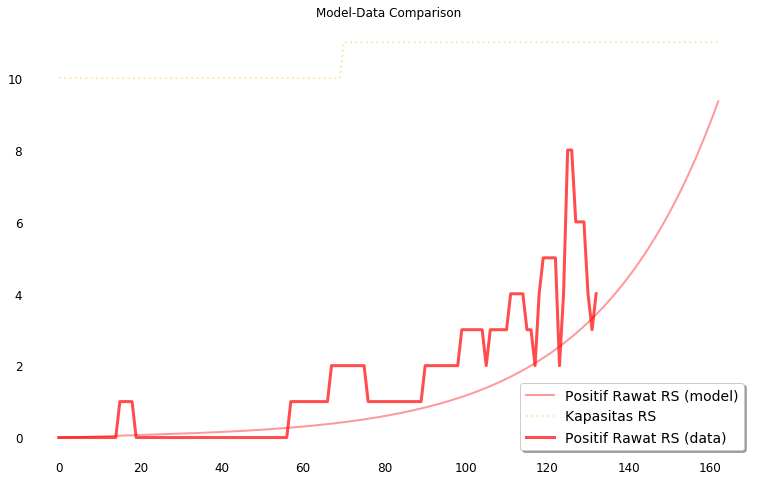

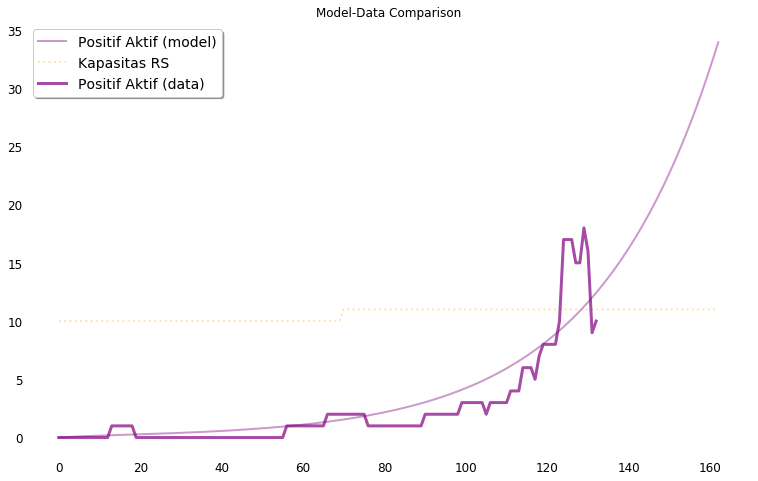

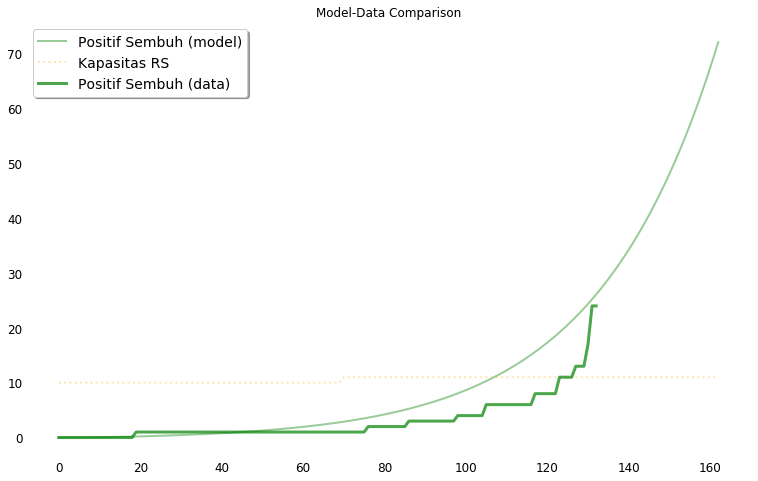

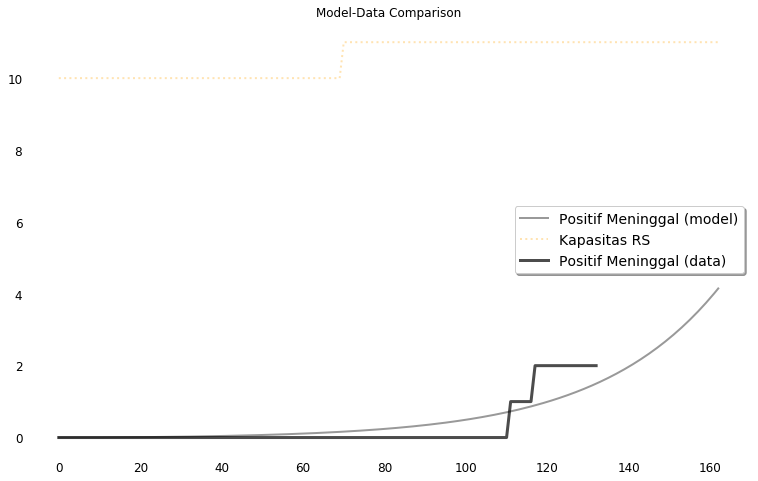

In [14]:
import matplotlib.pyplot as plt
for d in used_datasets:
    datasets = kabko.get_datasets([d], result.outbreak_shift)
    plotter.plot(
        plotter.plot_main_data, 
        datasets,
        length
    )
    plt.show()

plotter.plot(plotter.plot_main_lite);

plotter.plot(plotter.plot_daily_lite);

plotter.plot(plotter.plot_r0);

plotter.plot(plotter.plot_mortality_rate);

plotter.plot(plotter.plot_over);

plotter.plot(plotter.plot_dead);

plotter.plot(plotter.plot_healthcare);

### Model Scores

In [15]:
print("Last fit scores")
result.fit_scorer.report()
print()

Last fit scores
Varying Parameters: 8
Residual Mean (~0): [ 0.72231415 -0.37440964 -2.48065501 -0.03190714]
Residual Median (~0): [ 0.42215131 -0.49381298 -1.3773662  -0.05303569]
Max Error (~0): [ 5.29359686  7.50241451 10.5469315   1.10433517]
MAE (~0): [0.82740294 1.14057241 2.66760064 0.24917981]
MSE (~0): [ 1.59304102  3.18277186 16.26828685  0.14172309]
RMSE (~0): [1.26215729 1.78403247 4.03339644 0.37646128]
RMSLE (~0): [0.3897079  0.37724672 0.48400748 0.22424964]
Explained Variance: [0.65011846 0.80714248 0.4169475  0.68358362]
R2 (~1): [0.4797219  0.79825687 0.0622239  0.6812942 ]
Adjusted R2 (~1): [0.44615557 0.78524119 0.00172221 0.66073254]
SMAPE (~0): [0.62512508 0.5175412  0.41840026 0.86408576]
MASE (~0): [0.97132073 1.02755529 1.06586459 0.98966994]
Chi Square: [211.87445548962077, 423.3086576226897, 2163.6821511241615, 18.849171488657287]
Reduced Chi Square: [1.6949956439169662, 3.3864692609815172, 17.30945720899329, 0.1507933719092583]
AIC: [77.93075573323918, 169.98

In [16]:
print("Last fit scores flat")
result.fit_scorer.flatten().report()
print()

Last fit scores flat
Varying Parameters: 8
Residual Mean (~0): [-0.54116441]
Residual Median (~0): [-0.10939915]
Max Error (~0): [10.5469315]
MAE (~0): [1.22118895]
MSE (~0): [5.29645571]
RMSE (~0): [2.30140299]
RMSLE (~0): [0.38037432]
Explained Variance: [0.51210792]
R2 (~1): [0.48355176]
Adjusted R2 (~1): [0.47565197]
SMAPE (~0): [0.60628807]
MASE (~0): [0.97132073]
Chi Square: [2817.7144357251286]
Reduced Chi Square: [5.377317625429635]
AIC: [902.8641426827093]
AICc: [903.1394772907398]
BIC: [937.0772905974425]
Durbin-Watson: [0.09930904]
Residual Normal Test Shapiro p (p>a): [4.01940308e-27]
Residual Runs Test p (p>0.5): [4.43301423e-92]
F-Test Overall Significance p (p<a): [0.0037633]
F-Test pred-data p (p>a): [0.02010929]
F-Test residual-zero p (p>a): [3.14037124e-08]
KS-Test pred-data p (p>a): [1.27242902e-44]
KS-Test residual-normal p (p>a): [1.09339335e-22]
Prediction Interval p (p<a): [0.9924812]



In [17]:
if result.test_scorer:
    print("Test scores")
    result.test_scorer.report()
    print()

Test scores
Varying Parameters: 8
Residual Mean (~0): [ 1.33861331  1.62075977 -0.68352298 -0.18188994]
Residual Median (~0): [ 0.93739913  0.57169203 -1.00743365 -0.16405169]
Max Error (~0): [ 6.29334877 13.72933725 11.28165159  1.13390745]
MAE (~0): [1.39074635 1.79237891 1.33235306 0.29182229]
MSE (~0): [ 3.48448978 13.36909846  4.37213748  0.17904907]
RMSE (~0): [1.86667881 3.65637778 2.09096568 0.42314191]
RMSLE (~0): [0.60697989 0.4793737  0.30504673 0.29260508]
Explained Variance: [0.47278925 0.42968529 0.80494635 0.73922636]
R2 (~1): [-0.08534559  0.29022288  0.78160927  0.68012031]
Adjusted R2 (~1): [-0.18182075  0.22713158  0.76219676  0.65168656]
SMAPE (~0): [0.67343665 0.45148331 0.17952501 0.799845  ]
MASE (~0): [0.97932021 0.98760012 1.04258415 1.01278665]
Chi Square: [344.9644884866807, 1323.5407474668898, 432.84161074211926, 17.725858394075118]
Reduced Chi Square: [3.790818554798689, 14.54440381831747, 4.756501216946366, 0.19478965268214415]
AIC: [139.58384133794888, 27

In [18]:
if result.test_scorer:
    print("Test scores flat")
    result.test_scorer.flatten().report()
    print()

Test scores flat
Varying Parameters: 8
Residual Mean (~0): [0.52349004]
Residual Median (~0): [-0.00552442]
Max Error (~0): [13.72933725]
MAE (~0): [1.20182515]
MSE (~0): [5.3511937]
RMSE (~0): [2.31326473]
RMSLE (~0): [0.44070823]
Explained Variance: [0.5937406]
R2 (~1): [0.57181254]
Adjusted R2 (~1): [0.56296112]
SMAPE (~0): [0.52607249]
MASE (~0): [0.97505103]
Chi Square: [2119.072705089765]
Reduced Chi Square: [5.461527590437538]
AIC: [680.2185843554759]
AICc: [680.5906773787317]
BIC: [712.0698980455116]
Durbin-Watson: [0.20089951]
Residual Normal Test Shapiro p (p>a): [6.25738375e-27]
Residual Runs Test p (p>0.5): [3.66886892e-77]
F-Test Overall Significance p (p<a): [9.7821216e-29]
F-Test pred-data p (p>a): [0.01699461]
F-Test residual-zero p (p>a): [4.53466123e-06]
KS-Test pred-data p (p>a): [5.38001324e-17]
KS-Test residual-normal p (p>a): [1.74847028e-05]
Prediction Interval p (p<a): [1.]



### Save Params

Run code below ONLY if you want to save the parameters.

In [19]:
ModelDataRepo.save_fitting_result(result)